In [202]:
import os
import numpy as np
import pandas as pd
from gensim import models, similarities
from gensim.corpora.dictionary import Dictionary
import gzip
import json


In [203]:
import json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

### due to the humongus dataset size, I decided to downsample the dataset into 500,000 reviews.

In [204]:
def getDF(path): 
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
        if (i ==500000):
            break
        
    return pd.DataFrame.from_dict(df, orient = 'index')

In [205]:
df = getDF("Home_and_Kitchen.json.gz")

In [206]:
df

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5.0,2,True,"08 31, 2010",A3NSN9WOX8470M,0006564224,mmm,"I don't use these for their original use, and ...",Many uses...,1283212800,NaN,NaN
1,5.0,2,True,"04 2, 2010",A2AMX0AJ2BUDNV,0006564224,John R. Welch,"Seems a bit expensive for a plastic bottle, bu...",Dispenser bottle,1270166400,NaN,NaN
2,5.0,NaN,True,"11 5, 2015",A8LUWTIPU9CZB,0560467893,Linda Fahner,"Great product, love it!!",Five Stars,1446681600,NaN,NaN
3,4.0,4,True,"10 29, 2015",AABKIIHAL0L66,0560467893,TheBlueChain,This is a sturdy floating corner shelf! We mo...,"Sturdy Shelf, Poor Installation Instructions",1446076800,NaN,NaN
4,3.0,NaN,True,"09 9, 2015",A3DA0KIQ5OBK5C,0560467893,angelaarden,I purchased 4 of these shelves. they look grea...,Look great - one bad one...,1441756800,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,5.0,NaN,True,"11 13, 2017",A1HS8R80TM0SMG,B0000CFNXV,Carol Latourette,best brush and cleaner of all of them,Five Stars,1510531200,{'Color:': ' White'},NaN
499996,5.0,NaN,True,"11 10, 2017",A13BT0BD3K6RAH,B0000CFNXV,Anon,"This is great. Works well, designed well.",Five Stars,1510272000,{'Color:': ' White'},NaN
499997,5.0,NaN,True,"11 9, 2017",A148P80E1VPCGG,B0000CFNXV,Adam Bier,"As you lift it up, it opens. When you put it b...",OXO is worth the higher price,1510185600,{'Color:': ' White'},NaN
499998,5.0,NaN,True,"11 9, 2017",A3TXJRQEC0GHIN,B0000CFNXV,Slapering Hol,"Quality, looks really nice and brush is great....",looks really nice and brush is great,1510185600,{'Color:': ' White'},NaN


### For this assignment, we also use the reviewText for to analysis the topic modeling. 

In [207]:
review = [i for i in df['reviewText']]

In [208]:
review[:5]

["I don't use these for their original use, and in 1988 I purchased 2 and have needed replacements for the last year.  I never even thought of using the Internet to find new ones but to my pleasant surprise I found them immediately and actually paid LESS for them than I did in 1988!",
 "Seems a bit expensive for a plastic bottle, but I couldn't find better value on the Internet. Product performs as advertised. Very fast response from this supplier.",
 'Great product, love it!!',
 "This is a sturdy floating corner shelf!  We mounted a TV on the wall in the corner of the room and needed a shelf for the cable box. This product is perfect for our needs! We had to cut down the rear corner for the wires to run up the wall behind this shelf, but that wasn't an issue with the product itself. It looks great!  I'm giving it 4 stars because the enclosed instructions weren't very helpful at all. Thankfully my husband is good at handyman type things, so he was able to figure it out.",
 "I purchased

### There are two popular stop words cleaning tool. SpaCy and NLTK. For this assignment, I used NLTK to cleaning data and create corpus.

In [209]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [210]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
import string

[nltk_data] Downloading package punkt to /Users/phoebeli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/phoebeli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/phoebeli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/phoebeli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Then we can apply some general data cleaning processes

In [211]:
#Set up stop words and tokenizer
from nltk import word_tokenize, pos_tag, RegexpTokenizer
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

##### Regexp Tokenizer splits a string using a regular expression, which matches either the tokens or the separators between tokens.

##### When I process the data, I found that some of the sentense is not str type, so we firstly pick up the sentense which is try type.

In [212]:
cleaned_text = [i for i in review if type(i) == str ]
len(cleaned_text)

499875

#### To form a sentence, we need at least three words. So that we remove the sentence less than three words/elements.

In [213]:
cleaned_text = [i for i in cleaned_text if len(i) >= 3 ]
len(cleaned_text)

499090

#### Now we get a reasonably cleaned text data. The second step is to remove all the punkt elements and tokenized the sentences. To do this, we can se RegexpTokenizer, it will remove the punkt. https://www.kite.com/python/answers/how-to-remove-all-punctuation-marks-with-nltk-in-python. We can also tried to use different data processing steps to prepare the corpus. Here I tried WordNetLemmatizer, and Stemmer. And try to show which one perform better on the result. Here, we can pick up the first sentence to do a little experiment.

In [214]:
import gensim
from gensim import corpora 
from gensim.models import LdaModel 
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import operator
import pandas as pd
import gzip

In [215]:
exp = cleaned_text[0]
exp

"I don't use these for their original use, and in 1988 I purchased 2 and have needed replacements for the last year.  I never even thought of using the Internet to find new ones but to my pleasant surprise I found them immediately and actually paid LESS for them than I did in 1988!"

In [216]:
tokens = tokenizer.tokenize(exp.lower())
tokens[:10]

['i', 'don', 't', 'use', 'these', 'for', 'their', 'original', 'use', 'and']

In [217]:
## Using WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemm_tokens = [lemmatizer.lemmatize(token) for token in tokens]
print(lemm_tokens)

['i', 'don', 't', 'use', 'these', 'for', 'their', 'original', 'use', 'and', 'in', '1988', 'i', 'purchased', '2', 'and', 'have', 'needed', 'replacement', 'for', 'the', 'last', 'year', 'i', 'never', 'even', 'thought', 'of', 'using', 'the', 'internet', 'to', 'find', 'new', 'one', 'but', 'to', 'my', 'pleasant', 'surprise', 'i', 'found', 'them', 'immediately', 'and', 'actually', 'paid', 'le', 'for', 'them', 'than', 'i', 'did', 'in', '1988']


##### We use the Snowball stemmer here, which also allow you to pick different languge. Source: https://www.nltk.org/howto/stem.html

In [218]:
## Using SnowballStemmer
sb_stemmer = SnowballStemmer('english')
stemmed_tokens = [sb_stemmer.stem(token) for token in tokens]
print(stemmed_tokens)

['i', 'don', 't', 'use', 'these', 'for', 'their', 'origin', 'use', 'and', 'in', '1988', 'i', 'purchas', '2', 'and', 'have', 'need', 'replac', 'for', 'the', 'last', 'year', 'i', 'never', 'even', 'thought', 'of', 'use', 'the', 'internet', 'to', 'find', 'new', 'one', 'but', 'to', 'my', 'pleasant', 'surpris', 'i', 'found', 'them', 'immedi', 'and', 'actual', 'paid', 'less', 'for', 'them', 'than', 'i', 'did', 'in', '1988']


#### We can see that for most of the tokens, they are pretty much the same. However, the Snowball stemmer will form the adj or adv wrods into their originala form. For example, if we use lemmatizer, it will return original, but for snowball stemmer, it will return origin. 

#### Now to can put all these steps together, and create the corpus. We will first remove the stop words and the string format numbers, Lemmatize/Stemmer the tokens, and then added to the the texts lists.

In [219]:
num = [str(i) for i in range(10)]
num

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [220]:
lemm_texts = []

for s in cleaned_text:
    tokens = tokenizer.tokenize(s.lower()) #remove punkt and lower case the words. 
    stopped_tokens = [token for token in tokens if not token in stop_words] #remove the stop_words
    num_tokens = [token for token in stopped_tokens if not token in num] #remove the string type numbers
    lemmed_tokens = [lemmatizer.lemmatize(token) for token in num_tokens] # lemmatize the tokens
    lemm_texts.append(lemmed_tokens)# Adds tokens to new list "texts"

In [221]:
print(lemm_texts[0])

['use', 'original', 'use', '1988', 'purchased', 'needed', 'replacement', 'last', 'year', 'never', 'even', 'thought', 'using', 'internet', 'find', 'new', 'one', 'pleasant', 'surprise', 'found', 'immediately', 'actually', 'paid', 'le', '1988']


In [222]:
sb_texts = []
for s in cleaned_text:
    tokens = tokenizer.tokenize(s.lower()) #remove punkt and lower case the words. 
    stopped_tokens = [token for token in tokens if not token in stop_words] #remove the stop_words
    num_tokens = [token for token in stopped_tokens if not token in num] #remove the string type numbers
    stemmed_tokens = [sb_stemmer.stem(token) for token in num_tokens] # stem tokens
    sb_texts.append(stemmed_tokens)# Adds tokens to new list "texts"
    

In [223]:
print(sb_texts[0])

['use', 'origin', 'use', '1988', 'purchas', 'need', 'replac', 'last', 'year', 'never', 'even', 'thought', 'use', 'internet', 'find', 'new', 'one', 'pleasant', 'surpris', 'found', 'immedi', 'actual', 'paid', 'less', '1988']


In [224]:
#Create different text dict. 
lemm_texts_dict = corpora.Dictionary(lemm_texts)
lemm_texts_dict.save('review_lemm.dict') #save for future used. 
print(lemm_texts_dict)

Dictionary(85360 unique tokens: ['1988', 'actually', 'even', 'find', 'found']...)


In [225]:
sb_texts_dict = corpora.Dictionary(sb_texts)
sb_texts_dict.save('review_sb.dict') #save for future used. 
print(sb_texts_dict)

Dictionary(66133 unique tokens: ['1988', 'actual', 'even', 'find', 'found']...)


In [226]:
lemm_corpus = [lemm_texts_dict.doc2bow(text) for text in lemm_texts]
len(lemm_corpus)

499090

In [227]:
sb_corpus = [sb_texts_dict.doc2bow(text) for text in sb_texts]
len(sb_corpus)

499090

In [228]:
gensim.corpora.MmCorpus.serialize('lemm_review.mm', lemm_corpus)
gensim.corpora.MmCorpus.serialize('sb_review.mm', sb_corpus)

In [229]:
lda_model = gensim.models.LdaModel(lemm_corpus,alpha='auto', num_topics=5,id2word=lemm_texts_dict, passes=20)

lda_model.show_topics(num_topics=5,num_words=5)

[(0,
  '0.142*"coffee" + 0.109*"cup" + 0.046*"press" + 0.033*"filter" + 0.029*"maker"'),
 (1,
  '0.044*"timer" + 0.040*"marble" + 0.029*"thermometer" + 0.026*"potato" + 0.025*"temperature"'),
 (2,
  '0.047*"bag" + 0.041*"carpet" + 0.026*"brush" + 0.026*"cleaner" + 0.022*"vacuum"'),
 (3,
  '0.019*"pan" + 0.014*"water" + 0.013*"make" + 0.011*"use" + 0.008*"cake"'),
 (4,
  '0.021*"one" + 0.020*"great" + 0.014*"work" + 0.014*"use" + 0.012*"good"')]

In [230]:
lda_model = gensim.models.LdaModel(sb_corpus,alpha='auto', num_topics=5,id2word=sb_texts_dict, passes=20)

lda_model.show_topics(num_topics=5,num_words=5)

[(0,
  '0.061*"knife" + 0.045*"cut" + 0.026*"sharp" + 0.022*"slice" + 0.020*"blade"'),
 (1,
  '0.033*"one" + 0.012*"time" + 0.012*"would" + 0.011*"year" + 0.011*"use"'),
 (2,
  '0.036*"use" + 0.027*"great" + 0.018*"love" + 0.015*"make" + 0.014*"work"'),
 (3,
  '0.042*"clean" + 0.039*"carpet" + 0.028*"bottl" + 0.028*"marbl" + 0.026*"brush"'),
 (4,
  '0.111*"coffe" + 0.086*"cup" + 0.076*"water" + 0.035*"pour" + 0.034*"filter"')]

##### By observing the topics result, we can see that the lemm curpus will return the topic which related to how people feel about the products and how long they been use. The temmers will return different topic based on the products function. Like the carpet/cleaner and coffe/pan. 

In [231]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel
cm = CoherenceModel(model=lda_model, corpus=lemm_corpus, coherence='u_mass')
coherence = cm.get_coherence() 

In [232]:
coherence

-9.424404440805027

In [233]:
cm2 = CoherenceModel(model=lda_model, corpus=sb_corpus, coherence='u_mass')
coherence2 = cm2.get_coherence() 

In [234]:
coherence2

-2.862016486438164

###### Note: for u_mass, coherence approch to 0 will indicate a better result. So we can the stemmer process is better. 

#### Let's see how different models will affect the coherence score and topic result. 

In [235]:
model = models.LdaMulticore(sb_corpus, num_topics=5, id2word=sb_texts_dict, passes=2, workers=2, dtype=np.float64)

In [236]:
model.show_topics(num_topics = 5,num_words=5)

[(0,
  '0.055*"coffe" + 0.031*"cup" + 0.018*"press" + 0.018*"use" + 0.017*"make"'),
 (1,
  '0.023*"use" + 0.015*"make" + 0.012*"water" + 0.009*"get" + 0.009*"clean"'),
 (2, '0.028*"use" + 0.020*"pan" + 0.018*"love" + 0.014*"cook" + 0.014*"one"'),
 (3, '0.026*"one" + 0.012*"use" + 0.012*"year" + 0.010*"time" + 0.009*"work"'),
 (4,
  '0.042*"great" + 0.030*"work" + 0.022*"good" + 0.020*"product" + 0.019*"well"')]

In [237]:
cm3 = CoherenceModel(model=model, corpus=sb_corpus, coherence='u_mass')
coherence3 = cm3.get_coherence() 
coherence3

-2.1332628492501327

In [238]:
model2 = models.LdaMulticore(lemm_corpus, num_topics=5, id2word=lemm_texts_dict, passes=2, workers=2, dtype=np.float64)
model2.show_topics(num_topics = 5,num_words=5)


[(0,
  '0.020*"coffee" + 0.016*"one" + 0.015*"water" + 0.012*"cup" + 0.010*"time"'),
 (1,
  '0.048*"great" + 0.029*"work" + 0.026*"good" + 0.026*"easy" + 0.022*"well"'),
 (2,
  '0.020*"pan" + 0.015*"use" + 0.011*"make" + 0.009*"great" + 0.008*"size"'),
 (3,
  '0.011*"product" + 0.008*"would" + 0.008*"fit" + 0.007*"item" + 0.007*"amazon"'),
 (4,
  '0.032*"one" + 0.025*"knife" + 0.021*"love" + 0.015*"year" + 0.014*"bought"')]

In [239]:
cm4 = CoherenceModel(model=model, corpus=lemm_corpus, coherence='u_mass')
coherence4 = cm4.get_coherence() 
coherence4

-7.01099324594302

#### The LDAMulticore model slightly improve the coherence score in both lemmatizer and stemmer. 

#### Next, I exlpored how different topic numbers influence the coherence score the topic result. I select the range fomr 10 - 25. We use the LDAMulticore model and the stemmer to explore the result.

In [240]:
model_10 = models.LdaMulticore(sb_corpus, num_topics=10, id2word=sb_texts_dict, passes=2, workers=2, dtype=np.float64)
model_10.show_topics(num_topics = 10)

[(0,
  '0.029*"make" + 0.024*"use" + 0.023*"bowl" + 0.018*"garlic" + 0.012*"scoop" + 0.011*"bread" + 0.010*"chees" + 0.010*"dough" + 0.010*"ice" + 0.010*"slice"'),
 (1,
  '0.037*"pan" + 0.028*"use" + 0.024*"cook" + 0.014*"oven" + 0.012*"make" + 0.011*"bake" + 0.010*"stick" + 0.010*"clean" + 0.009*"grill" + 0.009*"heat"'),
 (2,
  '0.052*"one" + 0.035*"year" + 0.028*"use" + 0.019*"time" + 0.016*"last" + 0.016*"work" + 0.014*"replac" + 0.013*"old" + 0.013*"bought" + 0.011*"new"'),
 (3,
  '0.025*"use" + 0.024*"easi" + 0.022*"nice" + 0.018*"well" + 0.017*"size" + 0.016*"like" + 0.016*"great" + 0.015*"fit" + 0.015*"work" + 0.015*"clean"'),
 (4,
  '0.113*"love" + 0.038*"perfect" + 0.021*"gift" + 0.020*"use" + 0.019*"great" + 0.019*"bought" + 0.017*"one" + 0.016*"size" + 0.016*"color" + 0.013*"make"'),
 (5,
  '0.012*"product" + 0.011*"would" + 0.009*"one" + 0.009*"return" + 0.009*"review" + 0.009*"back" + 0.008*"get" + 0.007*"amazon" + 0.007*"item" + 0.007*"order"'),
 (6,
  '0.027*"lid" + 0.02

In [241]:
model_15 = models.LdaMulticore(sb_corpus, num_topics=15, id2word=sb_texts_dict, passes=2, workers=2, dtype=np.float64)
model_15.show_topics(num_topics = 10)

[(12,
  '0.088*"pan" + 0.031*"use" + 0.027*"cook" + 0.024*"stick" + 0.021*"iron" + 0.016*"clean" + 0.015*"cast" + 0.012*"heavi" + 0.011*"even" + 0.011*"non"'),
 (3,
  '0.083*"coffe" + 0.057*"cup" + 0.023*"make" + 0.022*"press" + 0.017*"pour" + 0.016*"use" + 0.016*"maker" + 0.015*"hot" + 0.014*"pot" + 0.014*"measur"'),
 (10,
  '0.024*"one" + 0.019*"product" + 0.015*"amazon" + 0.013*"purchas" + 0.012*"order" + 0.012*"year" + 0.012*"review" + 0.012*"would" + 0.011*"time" + 0.011*"buy"'),
 (2,
  '0.034*"perfect" + 0.034*"use" + 0.033*"size" + 0.021*"make" + 0.020*"garlic" + 0.019*"food" + 0.019*"grill" + 0.018*"great" + 0.018*"cook" + 0.017*"small"'),
 (7,
  '0.011*"like" + 0.011*"nice" + 0.010*"handl" + 0.010*"hold" + 0.009*"look" + 0.009*"use" + 0.008*"get" + 0.008*"fit" + 0.008*"would" + 0.008*"side"'),
 (9,
  '0.102*"great" + 0.092*"work" + 0.050*"well" + 0.049*"good" + 0.037*"product" + 0.031*"use" + 0.029*"easi" + 0.028*"price" + 0.021*"qualiti" + 0.018*"nice"'),
 (14,
  '0.034*"one"

In [242]:
model_20 = models.LdaMulticore(sb_corpus, num_topics=20, id2word=sb_texts_dict, passes=2, workers=2, dtype=np.float64)
model_20.show_topics(num_topics = 10)

[(10,
  '0.063*"cook" + 0.030*"use" + 0.019*"meat" + 0.017*"rice" + 0.016*"make" + 0.016*"perfect" + 0.015*"chicken" + 0.012*"great" + 0.012*"pot" + 0.012*"steak"'),
 (8,
  '0.073*"water" + 0.030*"lid" + 0.026*"cup" + 0.025*"measur" + 0.017*"seal" + 0.016*"pour" + 0.016*"use" + 0.015*"hot" + 0.013*"fill" + 0.011*"pyrex"'),
 (1,
  '0.095*"coffe" + 0.040*"cup" + 0.032*"press" + 0.023*"make" + 0.018*"maker" + 0.016*"pot" + 0.015*"use" + 0.014*"hot" + 0.013*"brew" + 0.012*"caraf"'),
 (12,
  '0.033*"bowl" + 0.027*"use" + 0.027*"garlic" + 0.023*"jar" + 0.017*"food" + 0.017*"make" + 0.015*"chees" + 0.012*"mixer" + 0.011*"juic" + 0.011*"grater"'),
 (11,
  '0.264*"great" + 0.259*"work" + 0.077*"well" + 0.028*"product" + 0.020*"price" + 0.018*"fine" + 0.015*"love" + 0.015*"littl" + 0.014*"expect" + 0.013*"job"'),
 (4,
  '0.017*"one" + 0.014*"use" + 0.013*"handl" + 0.011*"like" + 0.011*"plastic" + 0.009*"get" + 0.009*"would" + 0.009*"open" + 0.008*"hold" + 0.007*"side"'),
 (2,
  '0.018*"one" + 0.

In [243]:
model_25 = models.LdaMulticore(sb_corpus, num_topics=25, id2word=sb_texts_dict, passes=2, workers=2, dtype=np.float64)
model_25.show_topics(num_topics = 10)

[(15,
  '0.318*"good" + 0.102*"glass" + 0.052*"qualiti" + 0.046*"bottl" + 0.038*"pyrex" + 0.031*"product" + 0.027*"price" + 0.018*"wine" + 0.013*"nice" + 0.011*"pretti"'),
 (24,
  '0.014*"use" + 0.013*"attach" + 0.012*"put" + 0.011*"hold" + 0.010*"suction" + 0.010*"togeth" + 0.009*"assembl" + 0.009*"would" + 0.008*"cord" + 0.008*"place"'),
 (22,
  '0.046*"toaster" + 0.034*"knive" + 0.033*"fit" + 0.032*"plate" + 0.029*"egg" + 0.028*"side" + 0.024*"perfect" + 0.023*"wire" + 0.022*"roll" + 0.017*"sharpen"'),
 (1,
  '0.042*"item" + 0.040*"product" + 0.037*"excel" + 0.037*"order" + 0.036*"arriv" + 0.028*"amazon" + 0.026*"exact" + 0.025*"ship" + 0.023*"purchas" + 0.023*"thank"'),
 (9,
  '0.092*"press" + 0.069*"garlic" + 0.026*"juic" + 0.022*"marbl" + 0.020*"peel" + 0.018*"hand" + 0.016*"orang" + 0.016*"potato" + 0.014*"fruit" + 0.014*"pepper"'),
 (10,
  '0.051*"set" + 0.025*"color" + 0.019*"look" + 0.017*"dish" + 0.015*"piec" + 0.014*"beauti" + 0.010*"kitchen" + 0.010*"qualiti" + 0.009*"oxo"

In [265]:
from gensim.models.coherencemodel import CoherenceModel

In [284]:
def get_coherence_score(model): 
    cm = CoherenceModel(model=model, texts=sb_texts, coherence='c_v')
    coherence = cm.get_coherence() 
    return coherence
    

In [301]:
get_coherence_score(lda_model)

0.5743323720475952

In [302]:
lda_model_20 = gensim.models.LdaModel(sb_corpus,alpha='auto', num_topics=20,id2word=sb_texts_dict, passes=20)

lda_model_20.show_topics(num_topics=20,num_words=5)

[(0,
  '0.109*"item" + 0.097*"order" + 0.072*"amazon" + 0.056*"arriv" + 0.050*"return"'),
 (1,
  '0.148*"coffe" + 0.114*"cup" + 0.101*"water" + 0.053*"press" + 0.051*"hot"'),
 (2,
  '0.156*"pan" + 0.096*"cook" + 0.064*"dish" + 0.056*"bake" + 0.049*"oven"'),
 (3,
  '0.282*"great" + 0.238*"work" + 0.169*"well" + 0.153*"product" + 0.045*"expect"'),
 (4,
  '0.028*"like" + 0.025*"make" + 0.021*"get" + 0.020*"would" + 0.020*"clean"'),
 (5,
  '0.340*"heavi" + 0.118*"cleaner" + 0.089*"ok" + 0.059*"duti" + 0.047*"tray"'),
 (6,
  '0.162*"perfect" + 0.129*"size" + 0.099*"price" + 0.086*"fit" + 0.055*"store"'),
 (7,
  '0.626*"good" + 0.088*"counter" + 0.041*"orang" + 0.038*"valu" + 0.027*"assembl"'),
 (8,
  '0.229*"filter" + 0.176*"slice" + 0.100*"serv" + 0.067*"purpos" + 0.048*"fantast"'),
 (9,
  '0.230*"bowl" + 0.080*"mix" + 0.068*"attach" + 0.060*"mixer" + 0.035*"power"'),
 (10,
  '0.270*"qualiti" + 0.232*"recommend" + 0.162*"high" + 0.108*"excel" + 0.067*"definit"'),
 (11,
  '0.286*"love" + 0.

In [303]:
get_coherence_score(lda_model_20)

0.43027647708104205

In [304]:
lda_model_20.show_topics(num_topics=20,num_words=10)

[(0,
  '0.109*"item" + 0.097*"order" + 0.072*"amazon" + 0.056*"arriv" + 0.050*"return" + 0.044*"box" + 0.043*"thank" + 0.042*"ship" + 0.034*"packag" + 0.031*"fast"'),
 (1,
  '0.148*"coffe" + 0.114*"cup" + 0.101*"water" + 0.053*"press" + 0.051*"hot" + 0.046*"pour" + 0.045*"pot" + 0.024*"iron" + 0.022*"tast" + 0.019*"cast"'),
 (2,
  '0.156*"pan" + 0.096*"cook" + 0.064*"dish" + 0.056*"bake" + 0.049*"oven" + 0.046*"heat" + 0.044*"stick" + 0.040*"dishwash" + 0.035*"maker" + 0.032*"butter"'),
 (3,
  '0.282*"great" + 0.238*"work" + 0.169*"well" + 0.153*"product" + 0.045*"expect" + 0.036*"fine" + 0.012*"rubber" + 0.011*"peel" + 0.006*"can" + 0.005*"mechan"'),
 (4,
  '0.028*"like" + 0.025*"make" + 0.021*"get" + 0.020*"would" + 0.020*"clean" + 0.016*"use" + 0.015*"need" + 0.013*"much" + 0.013*"littl" + 0.013*"realli"'),
 (5,
  '0.340*"heavi" + 0.118*"cleaner" + 0.089*"ok" + 0.059*"duti" + 0.047*"tray" + 0.032*"defect" + 0.026*"charm" + 0.019*"im" + 0.017*"summer" + 0.016*"stabl"'),
 (6,
  '0.162

In [286]:
models = [model, model_10, model_15, model_20, model_25]
scores = []
for i in models: 
    scores.append(get_coherence_score(i))
    

In [287]:
scores

[0.4507248195220431,
 0.505085503980148,
 0.5403750777115519,
 0.544409689283705,
 0.5415424667593949]

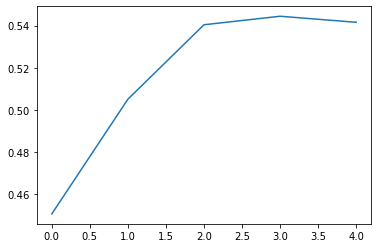

In [288]:
import matplotlib.pyplot as plt

plt.plot(scores)

### We can see the model 20 getting the best coherence result

### Now lets see if the topic is intuitive for human (like me)

In [291]:
model_20.show_topics(num_topics = 20, num_words =5)

[(0, '0.024*"time" + 0.024*"use" + 0.015*"read" + 0.014*"get" + 0.014*"oven"'),
 (1,
  '0.095*"coffe" + 0.040*"cup" + 0.032*"press" + 0.023*"make" + 0.018*"maker"'),
 (2,
  '0.018*"one" + 0.017*"amazon" + 0.016*"product" + 0.015*"review" + 0.014*"order"'),
 (3,
  '0.091*"best" + 0.085*"cut" + 0.056*"ever" + 0.051*"slice" + 0.027*"board"'),
 (4,
  '0.017*"one" + 0.014*"use" + 0.013*"handl" + 0.011*"like" + 0.011*"plastic"'),
 (5,
  '0.103*"knife" + 0.041*"sharp" + 0.032*"knive" + 0.023*"use" + 0.020*"kitchen"'),
 (6,
  '0.122*"easi" + 0.114*"clean" + 0.095*"use" + 0.023*"great" + 0.021*"love"'),
 (7, '0.029*"air" + 0.028*"room" + 0.021*"fan" + 0.018*"unit" + 0.010*"loud"'),
 (8,
  '0.073*"water" + 0.030*"lid" + 0.026*"cup" + 0.025*"measur" + 0.017*"seal"'),
 (9,
  '0.097*"pan" + 0.024*"iron" + 0.023*"stick" + 0.020*"grill" + 0.020*"use"'),
 (10,
  '0.063*"cook" + 0.030*"use" + 0.019*"meat" + 0.017*"rice" + 0.016*"make"'),
 (11,
  '0.264*"great" + 0.259*"work" + 0.077*"well" + 0.028*"pro

In [308]:
lda_model.show_topics(num_topics = 5, num_words =5)

[(0,
  '0.061*"knife" + 0.045*"cut" + 0.026*"sharp" + 0.022*"slice" + 0.020*"blade"'),
 (1,
  '0.033*"one" + 0.012*"time" + 0.012*"would" + 0.011*"year" + 0.011*"use"'),
 (2,
  '0.036*"use" + 0.027*"great" + 0.018*"love" + 0.015*"make" + 0.014*"work"'),
 (3,
  '0.042*"clean" + 0.039*"carpet" + 0.028*"bottl" + 0.028*"marbl" + 0.026*"brush"'),
 (4,
  '0.111*"coffe" + 0.086*"cup" + 0.076*"water" + 0.035*"pour" + 0.034*"filter"')]

In [309]:
lda_model_20.show_topics(num_topics = 20, num_words =5)

[(0,
  '0.109*"item" + 0.097*"order" + 0.072*"amazon" + 0.056*"arriv" + 0.050*"return"'),
 (1,
  '0.148*"coffe" + 0.114*"cup" + 0.101*"water" + 0.053*"press" + 0.051*"hot"'),
 (2,
  '0.156*"pan" + 0.096*"cook" + 0.064*"dish" + 0.056*"bake" + 0.049*"oven"'),
 (3,
  '0.282*"great" + 0.238*"work" + 0.169*"well" + 0.153*"product" + 0.045*"expect"'),
 (4,
  '0.028*"like" + 0.025*"make" + 0.021*"get" + 0.020*"would" + 0.020*"clean"'),
 (5,
  '0.340*"heavi" + 0.118*"cleaner" + 0.089*"ok" + 0.059*"duti" + 0.047*"tray"'),
 (6,
  '0.162*"perfect" + 0.129*"size" + 0.099*"price" + 0.086*"fit" + 0.055*"store"'),
 (7,
  '0.626*"good" + 0.088*"counter" + 0.041*"orang" + 0.038*"valu" + 0.027*"assembl"'),
 (8,
  '0.229*"filter" + 0.176*"slice" + 0.100*"serv" + 0.067*"purpos" + 0.048*"fantast"'),
 (9,
  '0.230*"bowl" + 0.080*"mix" + 0.068*"attach" + 0.060*"mixer" + 0.035*"power"'),
 (10,
  '0.270*"qualiti" + 0.232*"recommend" + 0.162*"high" + 0.108*"excel" + 0.067*"definit"'),
 (11,
  '0.286*"love" + 0.

In [310]:
cleaned_text[100]

"My wife bought this book for us and I just bought a copy for my friend's family because it is so so great! We loved the book. It was well written and easy for my 10 year old to read. I loved all of the different characters and see many new story lines for each ornament. Oliver has a great message to teach kids and a great holiday story. This will be a great addition to our Christmas traditions. Can't wait to share this with many others!"

In [311]:
model_20[sb_corpus[100]]

[(2, 0.2270049168697824),
 (6, 0.028070840778456733),
 (10, 0.09166732284487177),
 (11, 0.11963930996996504),
 (15, 0.48634604466964365),
 (18, 0.03136247377971932)]

In [312]:
lda_model[sb_corpus[100]]

[(1, 0.5360107), (2, 0.44886497)]

In [313]:
lda_model_20[sb_corpus[100]]

[(0, 0.025073307),
 (1, 0.014126736),
 (2, 0.04214069),
 (3, 0.09533815),
 (4, 0.21953374),
 (6, 0.016748365),
 (11, 0.14419077),
 (12, 0.020467699),
 (13, 0.020968208),
 (14, 0.26328394),
 (15, 0.066886485),
 (17, 0.030204039)]

### all three models predict this review is about the product that the person bought for at least a year. Which is makes sense to me But what I expect is the topic is related to the book products.

In [315]:
cleaned_text[20]

"Comfortable to use for with temperature beverage and fits in all my car's tiny cup holders without tipping. Not dishwashing, though. Handwash only."

In [316]:
model_20[sb_corpus[20]]

[(0, 0.0919971170637754), (6, 0.21409129904307816), (8, 0.6372449160866922)]

In [317]:
lda_model[sb_corpus[20]]

[(0, 0.1391819),
 (1, 0.18769242),
 (2, 0.4721105),
 (3, 0.012270988),
 (4, 0.18874416)]

In [318]:
lda_model_20[sb_corpus[20]]

[(0, 0.018084005),
 (1, 0.048789807),
 (2, 0.07040323),
 (3, 0.038302314),
 (4, 0.3500541),
 (6, 0.052626517),
 (7, 0.0112866135),
 (10, 0.03620902),
 (11, 0.024484698),
 (12, 0.010017516),
 (13, 0.084158316),
 (14, 0.14426544),
 (15, 0.014283783),
 (16, 0.012242328),
 (17, 0.051084016)]

### The review is about the beverage store products. Like a cup or mug. From the observation, I believe model_20 is getting the best result. The topic is related to the water, which is makes sense to me. The other also relavent, which indicates its a good review. 

### Even thought the LDA_model with 5 topic has the highest coherence result, I still belive model_20 is the best model. 

In [319]:
import pickle
 
# Save the best score. 
with open('best.model', 'wb') as files:
    pickle.dump(model_20, files)